Requirements Import

In [25]:
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import yaml
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
import torchvision
from torchvision.utils import save_image
from prov_data import *
from collections import OrderedDict

from datetime import datetime

import numpy as np
import torch
from scipy import stats
import random
import archs
import losses
from metrics import iou_score
from utils import AverageMeter, str2bool
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torch
import torch.distributed as dist
import os
from torch.utils.data import DataLoader, DistributedSampler
from scipy.stats import pearsonr, spearmanr
from easydict import EasyDict as edict

import warnings, os, sys

# Suppress specific warnings
warnings.filterwarnings("ignore")

# Suppress stderr messages (like multiprocessing errors)
sys.stderr = open(os.devnull, 'w')
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)

print("Seeded. Torch:", torch.__version__, "CUDA:", torch.version.cuda)



Seeded. Torch: 2.7.0+cu126 CUDA: 12.6


Input

In [26]:
data_root = "./../data/sample_test_data/data/"


## the following is the list of channel names. TRITC and Cy5 are background channels not used in analysis
channel_names=['DAPI', 
    'TRITC', #background channel not used in analysis
    'Cy5', #background channel not used in analysis
    'PD-1', 
    'CD14',
    'CD4',
    'T-bet', 
    'CD34', 
    'CD68', 
    'CD16', 
    'CD11c',
    'CD138',
    'CD20',
    'CD3',
    'CD8',
    'PD-L1',
    'CK',
    'Ki67',
    'Tryptase',
    'Actin-D',
    'Caspase3-D',
    'PHH3-B',
    'Transgelin']

Parse Arguments

In [27]:
import argparse

def str2bool(v):
    return v.lower() in ('true', '1')

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default="gigatime_training")
    parser.add_argument('--output_dir', default="./scratch") ## Place to save output files
    parser.add_argument('--gpu_ids', nargs='+', type=int) ## List of GPU ids to use, e.g. --gpu_ids 0 1 2
    parser.add_argument('--metadata', default="./../data/sample_metadata.csv") ## Change these if you download and place the data in another location
    parser.add_argument('--tiling_dir', default="./../data/sample_test_data/data/") ## Change these if you download and place the data in another location
    parser.add_argument('--epochs', default=1, type=int) ## Number of training epochs
    parser.add_argument('--batch_size', default=32, type=int) ## Batch size for training

    # model
    parser.add_argument('--arch', default='gigatime') ## Model architecture
    parser.add_argument('--input_channels', default=3, type=int) ## Number of input channels
    parser.add_argument('--num_classes', default=23, type=int) ## Number of output classes
    parser.add_argument('--input_w', default=512, type=int) ## Input width to resize to
    parser.add_argument('--input_h', default=512, type=int) ## Input height to resize to

    # loss
    parser.add_argument('--loss', default='BCEDiceLoss') ## Loss function

    return edict(vars(parser.parse_args([])))  # use [] so notebook runs

config = parse_args()
config

{'name': 'gigatime_training',
 'output_dir': './scratch',
 'gpu_ids': None,
 'metadata': './../data/sample_metadata.csv',
 'tiling_dir': './../data/sample_test_data/data/',
 'epochs': 1,
 'batch_size': 32,
 'arch': 'gigatime',
 'input_channels': 3,
 'num_classes': 23,
 'input_w': 512,
 'input_h': 512,
 'loss': 'BCEDiceLoss'}

Metrics

In [28]:
def calculate_correlations(matrix1, matrix2):
    """
    Calculate Pearson and Spearman correlation coefficients between two matrices.

    Args:
        matrix1 (np.ndarray): The first matrix.
        matrix2 (np.ndarray): The second matrix.

    Returns:
        dict: A dictionary containing Pearson and Spearman correlation coefficients.
    """
    assert matrix1.shape == matrix2.shape, "Matrices must have the same shape"
    b, c, h, w = matrix1.shape

    pearson_correlations = []
    spearman_correlations = []

    for channel in range(c):
        pearson_corrs = []
        spearman_corrs = []

        for batch in range(b):
            flat_matrix1 = matrix1[batch, channel].flatten()
            flat_matrix2 = matrix2[batch, channel].flatten()

            # Remove NaN values
            valid_indices = ~np.isnan(flat_matrix1.cpu().numpy()) & ~np.isnan(flat_matrix2.cpu().numpy())
            flat_matrix1 = flat_matrix1[valid_indices]
            flat_matrix2 = flat_matrix2[valid_indices]

            if len(flat_matrix1) > 0 and len(flat_matrix2) > 0:
                pearson_corr, _ = pearsonr(flat_matrix1.cpu().numpy(), flat_matrix2.cpu().numpy())
                spearman_corr, _ = spearmanr(flat_matrix1.cpu().numpy(), flat_matrix2.cpu().numpy())
            else:
                pearson_corr = np.nan
                spearman_corr = np.nan

            pearson_corrs.append(pearson_corr)
            spearman_corrs.append(spearman_corr)

        # Average correlations across the batch dimension
        pearson_correlations.append(np.nanmean(pearson_corrs))
        spearman_correlations.append(np.nanmean(spearman_corrs))

    return pearson_correlations, spearman_correlations
    

def split_into_boxes(tensor, box_size):
    # Get the dimensions of the tensor
    batch_size, channels, height, width = tensor.shape
    
    # Calculate the number of boxes along each dimension
    num_boxes_y = height // box_size
    num_boxes_x = width // box_size
    
    # Split the tensor into non-overlapping boxes
    boxes = tensor.unfold(2, box_size, box_size).unfold(3, box_size, box_size)
    boxes = boxes.contiguous().view(batch_size, channels, num_boxes_y, num_boxes_x, box_size, box_size)
    
    return boxes

def count_ones(boxes):
    # Count the number of ones in each box
    return boxes.sum(dim=(4, 5))



def get_box_metrics(pred, mask, box_size):
    # Split the images into boxes
    pred_boxes = split_into_boxes(pred, box_size)
    mask_boxes = split_into_boxes(mask, box_size)
    # Count the number of ones in each box
    pred_counts = count_ones(pred_boxes)
    mask_counts = count_ones(mask_boxes)
    
    # Calculate precision and MSE for the matrices
    mse = ((pred_counts.float() - mask_counts.float()) ** 2).mean(dim=0)    
    mean_mse_per_channel = mse.mean(dim=(1,2))

    mean_mse = mse.mean().item()

    pearson, spearman = calculate_correlations(pred_counts, mask_counts)
    
    return mean_mse_per_channel, pearson, spearman 



Loading the test data

In [29]:
metadata = pd.read_csv(config['metadata'])

import albumentations as geometric

val_transform = Compose([
    geometric.Resize(config['input_h'], config['input_w']),
    transforms.Normalize(),
])
    
metadata['dir_name'] = data_root 
metadata


,Unnamed: 0,dir_name,pair_name
0,0,./../data/sample_test_data/data/,10008_36140_556_556
1,1,./../data/sample_test_data/data/,11120_23908_556_556
2,2,./../data/sample_test_data/data/,10564_25576_556_556
3,3,./../data/sample_test_data/data/,0_16680_556_556
4,4,./../data/sample_test_data/data/,10008_37808_556_556
5,5,./../data/sample_test_data/data/,10008_35584_556_556
6,6,./../data/sample_test_data/data/,10008_38920_556_556
7,7,./../data/sample_test_data/data/,10008_6116_556_556
8,8,./../data/sample_test_data/data/,10008_21684_556_556
9,9,./../data/sample_test_data/data/,10008_21128_556_556


In [30]:

class HECOMETDataset_roi(torch.utils.data.Dataset):
    def __init__(self,all_tile_pair, tile_pair_df, transform,mask_noncell,
            cell_mask_label,
            dir_path ,
            window_size ,
            split,
            ):
        self.all_tile_pair = all_tile_pair
        self.tile_pair_df = tile_pair_df
        self.mask_noncell=mask_noncell
        self.transform = transform
        self.cell_mask_label=cell_mask_label
        self.dir_path = dir_path
        self.tile_pair_df = self.tile_pair_df
        self.all_tiles = [self.all_tile_pair.iloc[i]["pair_name"] for i in range(len(self.all_tile_pair))]

    def __len__(self):
        return len(self.tile_pair_df)

    def __getitem__(self, idx):
        # Get the tile pair data for the current index
        pair = self.tile_pair_df.iloc[idx]

        # Extract the input patch for the current tile 
        image_input_patch = get_image_roi(pair["pair_name"].split("_")[0], pair["pair_name"].split("_")[1], self.all_tiles, self.dir_path, pair)

        # Load and unpack binary comet data from the pickle file
        pkl_data = unpack_and_load(os.path.join(pair["dir_name"], pair["pair_name"] + "_comet_binary_thres_labels.pkl.gz"))

        # Extract the binary comet array mask from the loaded data
        mask = pkl_data["comet_array_binary"]  

        # Create cell masks for each channel based on whether it's nuclear or not

        cell_masks = [pkl_data["labels_dapi"] if channel in ["DAPI", "TRITC", "Cy5", "Ki67_1:150 - TRITC"] else pkl_data["labels_dapi_expanded"]
                            for channel in common_channel_list]    

        # Stack the cell masks along the last axis to create a 3D array (H, W, C)
        cell_masks = np.stack(cell_masks, axis=-1)   
        ### Note that the following processing was done after careful consideration with clinical domain experts
        # Extract nuclear and expanded nuclear labels for further processing
        labels_dapi = pkl_data['labels_dapi']  # Nuclear segmentation labels
        labels_dapi_expanded = pkl_data['labels_dapi_expanded']  # Expanded nuclear labels for rest 
          
        # Mask out non-cell regions if specified
        if self.mask_noncell:
            mask[cell_masks==0]=0 # Shape: (H, W, C)

        # Apply cell-level mask labeling if specified
        if self.cell_mask_label:
            # Label connected components in nuclear segmentation
            labeled_nuclei = label(labels_dapi) # Shape: (H, W)
            labeled_nuclei_props = regionprops(labeled_nuclei)

            # Label connected components in expanded nuclear segmentation
            labeled_cell = label(labels_dapi_expanded) # Shape: (H, W)
            labeled_cell_props = regionprops(labeled_cell)            
            
            # Initialize new mask with same shape as original
            mask_new=np.zeros_like(mask) # Shape: (H, W, C)

            # Process both nuclear and cellular regions
            for label_prop_mode, label_props in (("nuclei", labeled_nuclei_props),
                                                 ("cell", labeled_cell_props)):
                # Iterate through each labeled region
                for region_idx, region in enumerate(label_props):
                    # Get convex hull mask for the region
                    region_mask = region.convex_image # Shape: (region_height, region_width)                
                    # Get bounding box coordinates (minr, minc, maxr, maxc)
                    region_bbox= region.bbox
                    region_area_bbox=region.area_bbox

                    # Extract mask values within the bounding box
                    mask_bbox = mask[region_bbox[0]:region_bbox[2], region_bbox[1]:region_bbox[3], :] # Shape: (region_height, region_width, C)
                    # Calculate ratio of positive pixels for each channel within the region
                    region_ratio_list=(mask_bbox[region_mask].sum(axis=0)/region_mask.sum()) # Shape: (C,)
                    
                    # Select channels based on region type and threshold criteria
                    channel_idx_select=[]
                    for channel_idx, (channel, region_ratio) in enumerate(zip(common_channel_list, region_ratio_list)):
                        valid=False
                        # Determine if channel is valid for current region type
                        if label_prop_mode=="nuclei":
                            # Nuclear regions only process nuclear channels
                            if channel in ["DAPI", "TRITIC", "Cy5", "Ki67_1:150 - TRITC"]:
                                valid=True
                        elif label_prop_mode=="cell":
                            # Cellular regions process non-nuclear channels
                            if channel not in ["DAPI", "TRITIC", "Cy5", "Ki67_1:150 - TRITC"]:
                                valid=True
                        else:
                            raise ValueError(label_prop_mode)
                        
                        # Apply threshold to select positive channels
                        if valid:
                            # Use lower threshold (0.2) for Ki67, higher threshold (0.5) for others
                            if region_ratio>(0.2 if channel in ["Ki67_1:150 - TRITC"] else 0.5):
                                channel_idx_select.append(channel_idx)
                    
                    channel_idx_select=np.array(channel_idx_select)

                    # Update mask for selected channels
                    if len(channel_idx_select)>0:
                        # Initialize a full-sized mask with the same shape as the original image
                        full_region_mask = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2]), dtype=bool)  # Shape: (H, W, C)

                        # Set mask for each selected channel
                        for ch in channel_idx_select:
                            full_region_mask[region_bbox[0]:region_bbox[2], region_bbox[1]:region_bbox[3], ch] = region_mask  # Shape: (H, W, C)                        

                        # Update the new mask with positive labels
                        mask_new[full_region_mask] = 1  # Update the mask_new in the full image coordinates

            # Replace original mask with processed mask
            mask=mask_new
        
        # Apply data augmentation transforms
        augmented = self.transform(image=image_input_patch, mask=mask)
        img = augmented['image']
        # Convert image to float32 and CHW format
        img = img.astype('float32')
        img = img.transpose(2, 0, 1)  # Convert from HWC to CHW format
        mask = augmented['mask']
        # Convert mask to float32 and CHW format
        mask = mask.astype('float32')
        mask = mask.transpose(2, 0, 1)  # Convert from HWC to CHW format
        
        # Return image, mask, and metadata
        return img, mask, {'img_id': pair.name}
            

In [31]:
test_dataset = HECOMETDataset_roi(
        all_tile_pair=metadata,
        tile_pair_df=metadata,
        transform=val_transform,
        dir_path = data_root,
        window_size = 256,
        split="test",
        mask_noncell=True,
        cell_mask_label=True,
    )
 
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,
    drop_last=False)

Check the data 

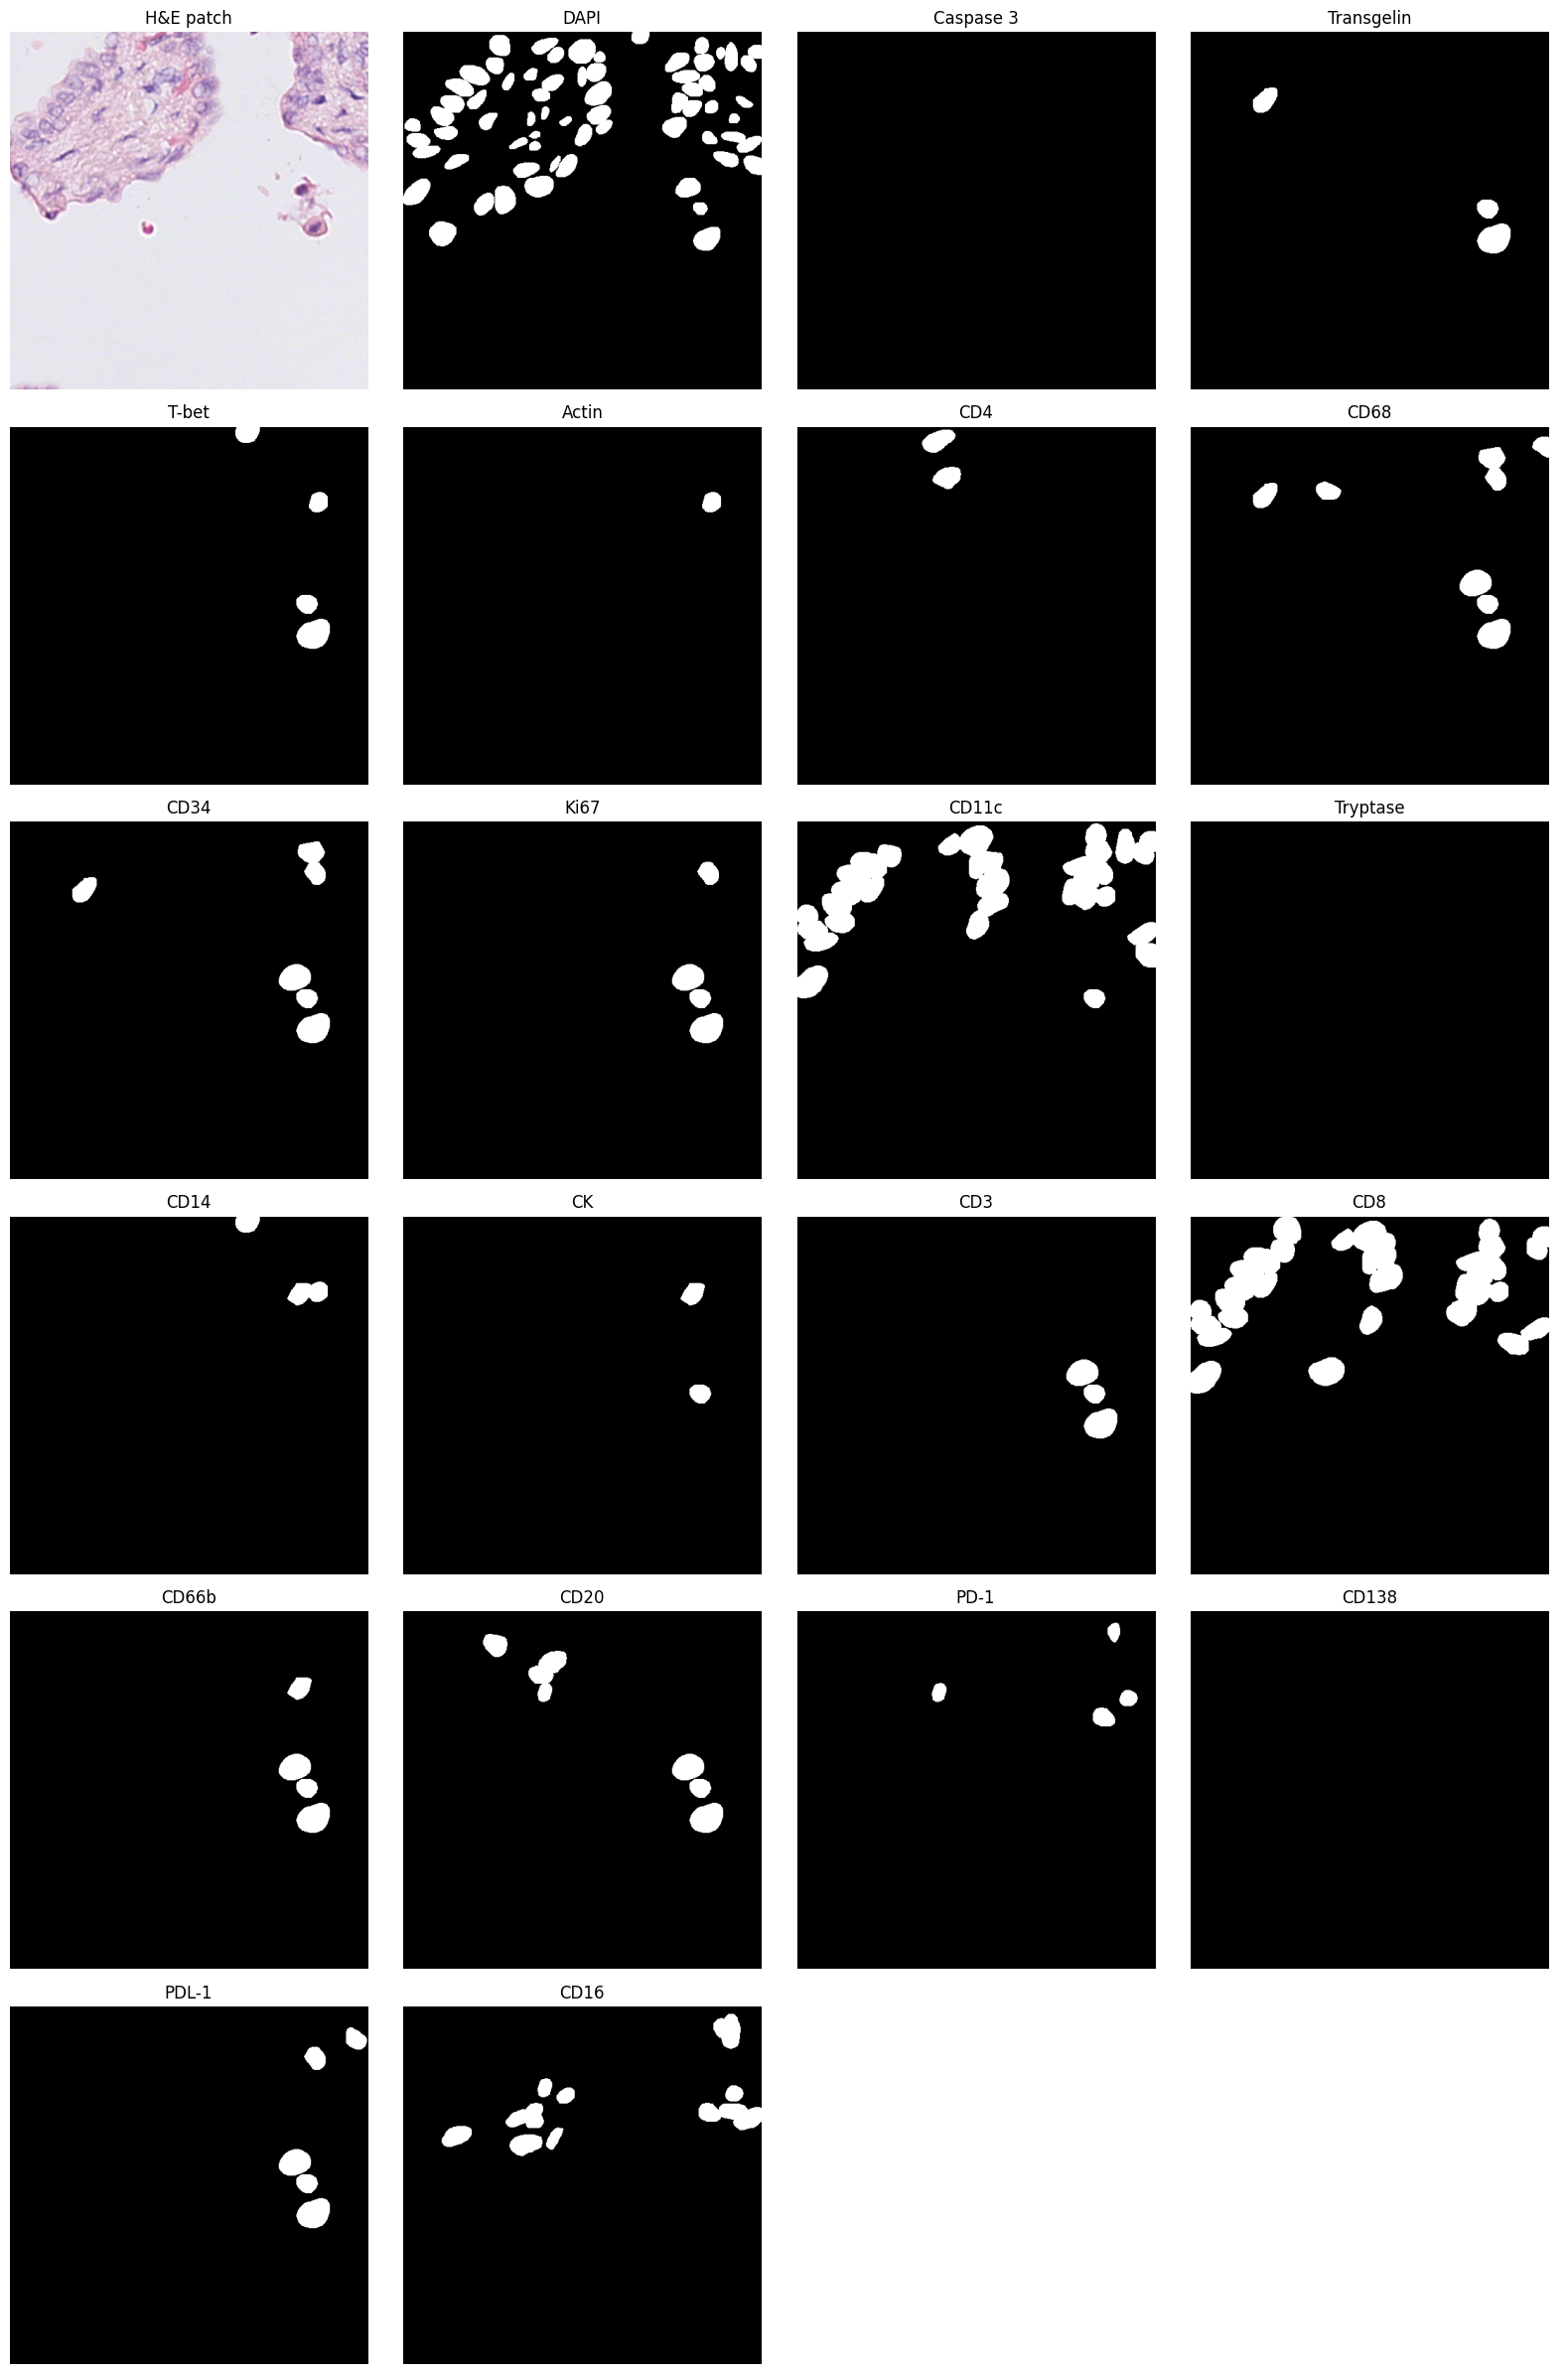

In [32]:
import matplotlib.pyplot as plt


def plot_sample(idx=0):
    img, mask, info = next(iter(test_loader))
    he_img = img[idx, :3].cpu().numpy()
    
    he_img = he_img * std[:, None, None] + mean[:, None, None]
    he_img = np.clip(he_img, 0, 1)
    he_img = np.transpose(he_img, (1, 2, 0))

    # Filter out channels named exactly 'TRITC' or 'Cy5'
    exclude_channels = ['TRITC', 'Cy5']
    filtered_indices = [i for i, name in enumerate(common_channel_list) if name not in exclude_channels]
    filtered_names = []
    for i in filtered_indices:
        name = common_channel_list[i]
        if ' - ' in name:
            name = name.split(' - ')[0].strip()
        filtered_names.append(name)

    n_cols = 4
    n_rows = (len(filtered_indices) + 1 + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    # Show H&E tile
    axes[0].imshow(he_img)
    axes[0].set_title("H&E patch")
    axes[0].axis('off')

    for plot_idx, ch in enumerate(filtered_indices):
        axes[plot_idx + 1].imshow(mask[idx, ch].cpu(), cmap='gray')
        axes[plot_idx + 1].set_title(filtered_names[plot_idx])
        axes[plot_idx + 1].axis('off')

    # Hide unused axes
    for ax in axes[len(filtered_indices) + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Usage: change idx to visualize different samples in the batch
plot_sample(idx=10)


Load the gigatime model

In [ ]:
# Initialize the model architecture using the specified config parameters
model = archs.__dict__[config['arch']](config['num_classes'],
                                                                                config['input_channels']).cuda()

# Load pre-trained weights from the specified checkpoint file
model.load_state_dict(torch.load("./../models/model.pth"))

print("=> loaded model %s" % config['arch'])

# Create output directory for saving model artifacts
os.makedirs(config['output_dir'] + "models/" +config['name'] +"/", exist_ok=True)

# Save configuration parameters to YAML file for reproducibility
with open(config['output_dir'] +'models/%s/config.yml' % config['name'], 'w') as f:
                yaml.dump(config, f)

criterion = losses.BCEDiceLoss().cuda()



=> loaded model gigatime


In [ ]:
def do_inference(input_image, model, window_size=256):
    b, c, h, w = input_image.shape
    output_logits = torch.zeros(b, config['num_classes'], h, w, device=input_image.device)
    with torch.no_grad():
        for i in range(0, h, window_size):
            for j in range(0, w, window_size):
                window = input_image[:, :, i:i + window_size, j:j + window_size].cuda()
                logits = model(window)
                output_logits[:, :, i:i + window_size, j:j + window_size] = logits
    return output_logits

def plot_predictions(idx=0):
    # Get batch from dataloader
    img, mask_batch, info = next(iter(test_loader))
    logits = do_inference(img.cuda(), model, window_size=256)
    loss = criterion(logits, mask_batch.cuda())  # logits for loss
    probs = torch.sigmoid(logits)
    pred = (probs > 0.5).float()
    pred = pred.cpu().numpy()
    mask = mask_batch[idx].cpu().numpy()

    # Prepare H&E patch (first 3 channels, unnormalize)
    he_img = img[idx, :3].cpu().numpy()
    he_img = he_img * std[:, None, None] + mean[:, None, None]
    he_img = np.clip(he_img, 0, 1)
    he_img = np.transpose(he_img, (1, 2, 0))

    # Filter out channels named  'TRITC' or 'Cy5'
    exclude_channels = ['TRITC', 'Cy5']
    filtered_indices = [i for i, name in enumerate(common_channel_list) if name not in exclude_channels]
    filtered_names = []
    for i in filtered_indices:
        name = common_channel_list[i]
        if ' - ' in name:
            name = name.split(' - ')[0].strip()
        filtered_names.append(name)

    # Prepare tensors for metrics
    output_image = torch.from_numpy(pred[idx, filtered_indices]).unsqueeze(0)
    target = torch.from_numpy(mask[filtered_indices]).unsqueeze(0)
    box_size = 8
    _, pearson, _ = get_box_metrics(output_image, target, box_size)

    # Sort channels 
    pearson_arr = np.array(pearson)
    nan_mask = np.isnan(pearson_arr)
    sort_order = np.argsort(nan_mask.astype(int) + (-pearson_arr if not nan_mask.all() else 0))
    sorted_names = [filtered_names[i] for i in sort_order]
    sorted_mask = [mask[filtered_indices[i]] for i in sort_order]
    sorted_pred = [pred[idx, filtered_indices[i]] for i in sort_order]

    num_sorted = len(sort_order)
    fig, axs = plt.subplots(num_sorted + 1, 2, figsize=(8, 4 * (num_sorted + 1)))

    # Show H&E patch
    axs[0, 0].imshow(he_img)
    axs[0, 0].set_title("H&E patch")
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')

    # Show sorted mask channels and predictions
    for row_idx in range(num_sorted):
        axs[row_idx + 1, 0].imshow(sorted_mask[row_idx], cmap='gray')
        axs[row_idx + 1, 0].set_title(f'Actual mIF: {sorted_names[row_idx]}')
        axs[row_idx + 1, 0].axis('off')

        axs[row_idx + 1, 1].imshow(sorted_pred[row_idx], cmap='gray')
        axs[row_idx + 1, 1].set_title(f'Virtual mIF: {sorted_names[row_idx]}')
        axs[row_idx + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()



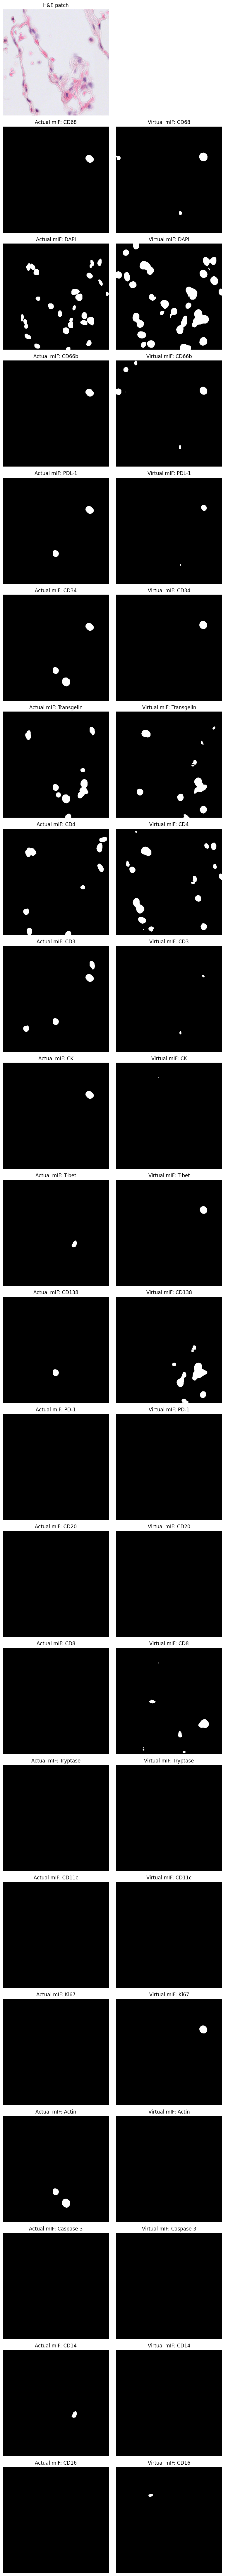

In [44]:
plot_predictions(idx=12)

Testing code for calcuting eval metrics

In [47]:
def test(config, val_loader, model, criterion,  common_channel_list):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}


    pearson_per_class_meters = [AverageMeter() for _ in range(config['num_classes'])]
    # switch to evaluate mode


    window_size = 256
    model.eval()
    count = 0


    with torch.no_grad():
        pbar = tqdm.tqdm(total=len(val_loader))
        
        for data in val_loader:
            count+=1
            input, target_g, name = data
            
            ## we make the image coarse so that registration errors do not affect much during the training, please note that this is how the model was trained so we use the same setup during testing
            downsampled_image = F.interpolate(target_g, scale_factor=1/8, mode='bilinear', align_corners=False)
            target = F.interpolate(downsampled_image, size=(512,512), mode='bilinear', align_corners=False)

            target = target.cuda()

            output_image = torch.zeros_like(target).cuda()

            logits = do_inference(input.cuda(), model, window_size) ## this takes a patch of size 256 and deoes inference on smaller 256*256 windows
            probs = torch.sigmoid(logits)
            output_image = (probs > 0.5).float().cuda()

            loss = criterion(output_image, target)

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg)
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
            box_size = 8

            _, pearson, spearman = get_box_metrics(output_image, target, box_size) ##this gets the pearson correlation and mse after splitting the image into boxes of size 8*8 for each channel for clearer interpretation


            for class_idx, value in enumerate(pearson):
                if not np.isnan(value):
                    pearson_per_class_meters[class_idx].update(value, target.size(0))


    postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg)
            ]+[(channel_name, pearson_per_class_meters[channel_idx].avg) for channel_idx, channel_name in enumerate(common_channel_list)]
            )
    pbar.set_postfix(postfix)
    pbar.close()


    convert_to_csv(config,  pearson_per_class_meters, "Results", common_channel_list) ## this saves the pearson correlation results in a csv file

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)]\
                            +[(f'{channel_name}_pearson', pearson_per_class_meters[channel_idx].avg) for channel_idx, channel_name in enumerate(common_channel_list)]\
            )

def convert_to_csv(config, pearson_dict, name, common_channel_list):


    pear_per_class_avg = [pear.avg for pear in pearson_dict]
    pear_per_class_std = [pear.std for pear in pearson_dict]
    combined = list(zip(pear_per_class_avg, common_channel_list, pear_per_class_std))
    sorted_combined = sorted(combined, key=lambda x: x, reverse = True)
    pearson_per_class_avg, channel_names, pearson_per_class_std= zip(*sorted_combined)

    # Get today's date in YYYY-MM-DD format
    today_date = datetime.now().strftime("%Y-%m-%d")

    header = [ "Channel", "Pearson_Avg", "Pearson_Std"]

    data = {'Channel': channel_names, f'Pearson_Average {name}': pearson_per_class_avg, f'Pearson_Standard Deviation {name}': pearson_per_class_std
            }
    df = pd.DataFrame(data)
    df.to_csv(config['output_dir'] + "models/" + config['name'] + "/" + f'/{name}_per_channel_{today_date}_test_results.csv', index=False)




 

In [48]:
test_log_silver = test(config, test_loader, model, criterion, common_channel_list=common_channel_list)


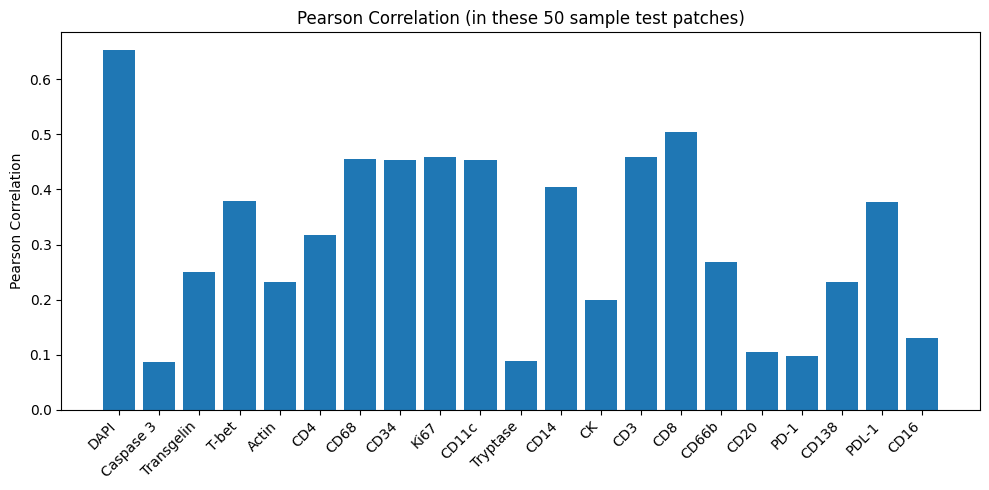

In [ ]:
import matplotlib.pyplot as plt

# Extract Pearson values and channel names from test_log_silver
pearson_dict = {k: v for k, v in test_log_silver.items() if k.endswith('_pearson')}

# Remove channels containing 'TRITC' or 'Cy5'
filtered = {k: v for k, v in pearson_dict.items() if k not in ['TRITC_pearson', 'Cy5_pearson']}

# Remove any text after '-' in channel names
def clean_channel_name(name):
    base = name.replace('_pearson', '')
    if ' - ' in base:
        base = base.split(' - ')[0].strip()
    return base

channels = [clean_channel_name(k) for k in filtered.keys()]
values = list(filtered.values())

plt.figure(figsize=(10, 5))
plt.bar(channels, values)
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=45, ha='right')
plt.title('Pearson Correlation (in these 50 sample test patches)')
plt.tight_layout()
plt.show()